# 00 Introduction

* Author: Lukas Galeta
* Date: December 2024
* University: University of Michigan (UMich)
* Course: Applied Machine Learning


Description

This project is part of an academic course at the University of Michigan and
focuses on fine-tuning a pre-trained GPT-2 model to generate solutions and
explanations for various math and science problems. The goal is to explore how
language models can assist in solving mathematical equations, providing
explanations of concepts, and generating step-by-step solutions.
The model has been trained on a dataset of math and science problems, aiming to
create a reliable chatbot capable of answering complex queries related to
mathematics and science.

This script includes the process of model fine-tuning, evaluation on test
prompts, and comparison of model outputs with the standard GPT-2 model. It
also demonstrates how to use the model for real-time query generation.

#01 Install & Import

In [ ]:
pip install datasets

Imports

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW

from datasets import load_dataset

import gc

import matplotlib.pyplot as plt
import numpy as np

#02 Tokenizer & Model

The tokenizer is responsible for converting text into numerical representations (tokens)
that the model can understand. The 'gpt2-medium' tokenizer is loaded from the Hugging Face model hub.
Padding is configured to ensure all input sequences have the same length, using the end-of-sequence token.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2-medium")
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The 'gpt2-medium' model is a pre-trained causal language model from the Hugging Face model hub.
It's designed to predict the next word in a sequence, making it suitable for text generation tasks.

In [ ]:
model = AutoModelForCausalLM.from_pretrained("gpt2-medium")

This line specifies the device to run the model on. 'cpu' is used here, indicating the CPU.
For GPU usage, change it to 'cuda' if a compatible GPU is available.

In [ ]:
device = torch.device("cpu")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50257, bias=False)
)

#03 Data

* Dataset: HuggingFaceTB - Math Tasks
* Source: Hugging Face Datasets
* Dataset URL: https://huggingface.co/datasets/HuggingFaceTB/math_tasks/tree/main

A dataset containing a variety of math-related tasks, including problems in
algebra, calculus, geometry, and probability. It is designed to help fine-tune
language models for solving and explaining math problems.

In [ ]:
# Dataset class
class TextDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings.input_ids)

    def __getitem__(self, idx):
        return {key: tensor[idx] for key, tensor in self.encodings.items()}

In [ ]:
dataset = load_dataset("HuggingFaceTB/smoltalk", "all", split="train")

Dataset is plited due to demostration

In [ ]:
split_index = len(dataset) // 10

dataset1 = dataset.select(range(split_index))

Tokenization of dataset

In [ ]:
train_texts = dataset1['messages']

flattened_messages = [message for sublist in train_texts for message in sublist]
train_texts = "\n\n".join([message['content'] for message in flattened_messages])

encodings = tokenizer(train_texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
data = TextDataset(encodings)

dataloader = DataLoader(data, batch_size=8, shuffle=True)

# 04 Fine-tuning

Optimizer

In [ ]:
# AdamW Optimizer Parameters:

# `model.parameters()`: Specifies the model's parameters to optimize, i.e., the parameters of the neural network that the optimizer will update during training.
# `lr=5e-5`: Sets the learning rate to 5e-5. The learning rate controls how big the steps are when the optimizer adjusts the model's parameters. A smaller value ensures more controlled, slower learning.
# `weight_decay=0.01`: Applies weight decay (L2 regularization) to prevent the model from overfitting. This penalizes large weights, encouraging the model to learn simpler representations.
# `betas=(0.9, 0.98)`: These values control the running averages of the first and second moments of the gradients. `0.9` is for the first moment (mean of gradients), and `0.98` is for the second moment (uncentered variance of gradients). These parameters help stabilize the optimization process.
# `eps=1e-8`: A small constant added to the denominator to ensure numerical stability during optimization. Prevents division by zero or very small values.

optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01, betas=(0.9, 0.98), eps=1e-8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


This section fine-tunes the pre-trained GPT model by training it for 100 epochs. In each epoch, the model processes data batches, calculates loss, and updates its parameters using backpropagation and the optimizer. Memory management is performed via garbage collection, and the loss is printed after each batch to monitor progress.

In [ ]:
model.train()
for epoch in range(10):  # Train for 3 epochs
    print(f"Epoch {epoch + 1}")
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        gc.collect()

        print(f"Loss: {loss.item()}")

Epoch 1
Loss: 1.9794726371765137
Epoch 2
Loss: 1.609305500984192
Epoch 3
Loss: 1.3151721954345703
Epoch 4
Loss: 1.2104551792144775
Epoch 5
Loss: 1.021491527557373
Epoch 6
Loss: 0.8429755568504333
Epoch 7
Loss: 0.7403225898742676
Epoch 8
Loss: 0.6176673173904419
Epoch 9
Loss: 0.5172518491744995
Epoch 10
Loss: 0.47548505663871765


Export model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

save_path = '/content/drive/MyDrive/fine_tuned_gpt2'  # Update with your desired path

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


('/content/drive/MyDrive/fine_tuned_gpt2/tokenizer_config.json',
 '/content/drive/MyDrive/fine_tuned_gpt2/special_tokens_map.json',
 '/content/drive/MyDrive/fine_tuned_gpt2/vocab.json',
 '/content/drive/MyDrive/fine_tuned_gpt2/merges.txt',
 '/content/drive/MyDrive/fine_tuned_gpt2/added_tokens.json',
 '/content/drive/MyDrive/fine_tuned_gpt2/tokenizer.json')

#05 Validate model

The validation section consists of a list of mathematical prompts designed to test the performance of a fine-tuned model. These prompts cover a wide range of topics, including solving algebraic equations, differentiating and integrating functions, solving geometry problems, and more. The goal is to evaluate the model's ability to handle various mathematical concepts and provide accurate and relevant answers. By using these questions, the fine-tuned model is assessed on its ability to generalize and solve different types of math problems, helping to ensure that the model's training has effectively captured the necessary mathematical knowledge.

In [ ]:
validation_prompts = [
    "Solve for x: 2x + 3 = 7.",
    "What is the derivative of x^2 + 3x + 4?",
    "Explain the Pythagorean theorem.",
    "What is the integral of sin(x) dx?",
    "If a triangle has sides 3, 4, and 5, is it a right triangle?",
    "Expand the expression (x + 2)^3.",
    "What is the area of a circle with radius 5?",
    "Simplify the fraction 36/48.",
    "Convert 0.75 to a fraction.",
    "Find the greatest common divisor of 28 and 42.",
    "Explain the concept of a prime number.",
    "If a car travels 60 miles in 2 hours, what is its average speed?",
    "What is the sum of the angles in a hexagon?",
    "Calculate the probability of rolling a sum of 7 with two dice.",
    "What is the volume of a sphere with radius 3?",
    "What is the square root of 144?",
    "If f(x) = x^2, what is f(3)?",
    "Solve: 5x - 2 = 18.",
    "What are the first five terms of the Fibonacci sequence?",
    "Explain what a logarithm is.",
    "What is the value of pi to two decimal places?",
    "Solve for y: 3y - 4 = 11.",
    "What is the derivative of 3x^3 + 2x^2 + x?",
    "Find the volume of a cylinder with radius 4 and height 10.",
    "What is the slope of the line passing through the points (1, 2) and (3, 6)?",
    "Solve for x: x^2 - 4 = 0.",
    "Find the distance between the points (1, 2) and (4, 6).",
    "Convert 45 degrees to radians.",
    "If the area of a rectangle is 20 and the length is 5, what is the width?",
    "Find the derivative of 5e^x.",
    "What is the cosine of 90 degrees?",
    "What is the inverse of the function f(x) = 2x + 3?",
    "Simplify: 5x - 3x + 2.",
    "Solve for x: 3x + 5 = 2x + 12.",
    "What is the sum of the interior angles of a quadrilateral?",
    "What is the cube root of 27?",
    "Find the perimeter of a triangle with sides 5, 12, and 13.",
    "What is the factorial of 6?",
    "Solve for x: x^2 + 2x - 8 = 0.",
    "What is the equation of a line passing through (2, 3) and (4, 7)?",
    "How many prime numbers are less than 20?",
    "If a car accelerates at 3 m/s² for 5 seconds, what is its final velocity?",
    "What is the area of a right triangle with base 6 and height 8?",
    "Calculate the derivative of sin(x) + cos(x).",
    "What is the value of log(100) base 10?",
    "Find the sum of the first 10 positive integers.",
    "What is the perimeter of a square with side length 7?",
    "Solve for x: 2x^2 - 3x + 1 = 0.",
    "What is the area of a trapezoid with bases 5 and 7, and height 4?",
    "What is the median of the numbers [3, 7, 5, 9, 2]?",
    "What is the equation of a circle with center (0, 0) and radius 4?",
    "What is the quadratic formula?",
    "Simplify: (x + 1)(x - 1)."
]

Generating responses for test prompts. The aim is to compare old and new model.

In [ ]:
fine_tuned_outputs = []
model.eval()
with torch.no_grad():
    for prompt in validation_prompts:
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
        output = model.generate(input_ids, max_length=50, pad_token_id=tokenizer.eos_token_id)
        fine_tuned_outputs.append(tokenizer.decode(output[0], skip_special_tokens=True))


standard_model = AutoModelForCausalLM.from_pretrained("gpt2-medium").to(device)
standard_outputs = []
standard_model.eval()
with torch.no_grad():
    for prompt in validation_prompts:
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
        output = standard_model.generate(input_ids, max_length=50, pad_token_id=tokenizer.eos_token_id)
        standard_outputs.append(tokenizer.decode(output[0], skip_special_tokens=True))

for i, prompt in enumerate(validation_prompts):
    print(f"Prompt: {prompt}")
    print(f"Fine-Tuned Model Output: {fine_tuned_outputs[i]}")
    print(f"Standard Model Output: {standard_outputs[i]}")
    print("-" * 50)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Prompt: Solve for x: 2x + 3 = 7.
Fine-Tuned Model Output: Solve for x: 2x + 3 = 7.

The solution is given by

x = 2 + 3

The value of x is given by

x = 2 + 3 / 3 = 4

The value
Standard Model Output: Solve for x: 2x + 3 = 7.

The solution is:

x = 2x + 3 = 7

x = 2x + 3 = 7 x = 2x + 3 = 7

x =
--------------------------------------------------
Prompt: What is the derivative of x^2 + 3x + 4?
Fine-Tuned Model Output: What is the derivative of x^2 + 3x + 4?

The derivative of x^2 + 3x + 4 is given by

x = 3 + 4

The derivative of x is given by

2x
Standard Model Output: What is the derivative of x^2 + 3x + 4?

The derivative of x^2 + 3x + 4 is the product of the two terms.

The derivative of x^2 + 3x + 4 is the
--------------------------------------------------
Prompt: Explain the Pythagorean theorem.
Fine-Tuned Model Output: Explain the Pythagorean theorem.

The Pythagorean theorem states that the product of two numbers x and y is the product of the squares of their lengths.

The length

Perplexity scores

In [ ]:
def compute_perplexity(model, text):
    inputs = tokenizer(text, return_tensors="pt").input_ids.to(device)
    with torch.no_grad():
        outputs = model(inputs, labels=inputs)
        loss = outputs.loss
    return torch.exp(loss).item()

for i, prompt in enumerate(validation_prompts):
    print(f"Fine-Tuned Model Perplexity for '{prompt}': {compute_perplexity(model, fine_tuned_outputs[i])}")
    print(f"Standard Model Perplexity for '{prompt}': {compute_perplexity(standard_model, standard_outputs[i])}")

Fine-Tuned Model Perplexity for 'Solve for x: 2x + 3 = 7.': 5.251689910888672
Standard Model Perplexity for 'Solve for x: 2x + 3 = 7.': 4.7754716873168945
Fine-Tuned Model Perplexity for 'What is the derivative of x^2 + 3x + 4?': 3.4351444244384766
Standard Model Perplexity for 'What is the derivative of x^2 + 3x + 4?': 3.2784314155578613
Fine-Tuned Model Perplexity for 'Explain the Pythagorean theorem.': 3.0808322429656982
Standard Model Perplexity for 'Explain the Pythagorean theorem.': 3.195242404937744
Fine-Tuned Model Perplexity for 'What is the integral of sin(x) dx?': 4.767833709716797
Standard Model Perplexity for 'What is the integral of sin(x) dx?': 4.503958225250244
Fine-Tuned Model Perplexity for 'If a triangle has sides 3, 4, and 5, is it a right triangle?': 4.336016654968262
Standard Model Perplexity for 'If a triangle has sides 3, 4, and 5, is it a right triangle?': 3.116708278656006
Fine-Tuned Model Perplexity for 'Expand the expression (x + 2)^3.': 5.024599552154541
St

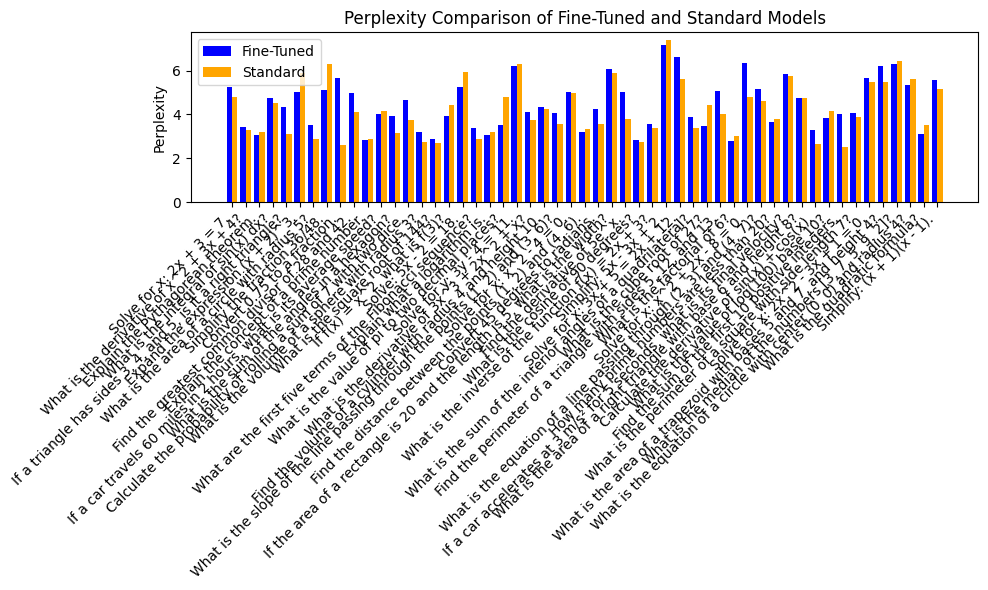

In [ ]:


# Plot Perplexity Comparison
def plot_perplexities(validation_prompts, fine_tuned_perplexities, standard_perplexities):
    indices = np.arange(len(validation_prompts))

    plt.figure(figsize=(10, 6))
    plt.bar(indices - 0.2, fine_tuned_perplexities, width=0.4, label="Fine-Tuned", color="blue")
    plt.bar(indices + 0.2, standard_perplexities, width=0.4, label="Standard", color="orange")
    plt.xticks(indices, validation_prompts, rotation=45, ha="right")
    plt.ylabel("Perplexity")
    plt.title("Perplexity Comparison of Fine-Tuned and Standard Models")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Calculate perplexities for visualization
fine_tuned_perplexities = [compute_perplexity(model, output) for output in fine_tuned_outputs]
standard_perplexities = [compute_perplexity(standard_model, output) for output in standard_outputs]

# Visualize Outputs and Perplexities
plot_perplexities(validation_prompts, fine_tuned_perplexities, standard_perplexities)
